In [68]:
!pip install patool
!pip install nmslib
!pip install tqdm
!pip install ipdb

import patoolib

You should consider upgrading via the '/home/rossignolle/Memoire/ImplementRichie/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rossignolle/Memoire/ImplementRichie/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rossignolle/Memoire/ImplementRichie/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/rossignolle/Memoire/ImplementRichie/env/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
NUM_CATS = 46
IMAGE_SIZE = 512

In [2]:
import os.path
from os import path

def resize_image(image_path):
  if path.exists(image_path) :
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img
  else :
    print("false")

In [3]:
import sys 
import tensorflow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import urllib
import json
import sys
import tarfile
import os
import nmslib
import cv2
from glob import glob

/home/rossignolle/Memoire/ImplementRichie/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rossignolle/Memoire/ImplementRichie/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rossignolle/Memoire/ImplementRichie/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rossign

In [4]:
from PIL import Image
from tqdm import tqdm
from pylab import imshow
#from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad

import tensorflow as tf
import numpy as np

In [73]:
def download_googlenet():
    """
    Download and extract googlenet model from the downloaded tar file 
    """
    
    # location of the model
    model_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
    
    # folder where to save the tar file to download
    save_dir = "googlenet"
    
    # create the save dir if it not already exists
    os.makedirs(save_dir, exist_ok=True)   
    
    # file name
    fname = "googlenet.tgz"
    
    # file path
    fpath = os.path.join(save_dir, "googlenet.tgz")
    
    # define a progress function
    def _progress(count, block_size, total_size):
        sys.stdout.write('\r[INFO] Downloading %s %.1f%%' % (fname, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
    
    # download with urllib
    fpath, _ = urllib.request.urlretrieve(model_url, fpath, _progress)
    
    print()
    statinfo = os.stat(fpath)
    print('Successfully downloaded', fname, statinfo.st_size, 'bytes.')
    tarfile.open(fpath, 'r:gz').extractall(save_dir)

In [74]:
# download_googlenet()

In [5]:
def load_model():
    """
    Load the model from the .pb file of GoogLeNet.
    """
    
    graph = 'googlenet/classify_image_graph_def.pb'
    
    # download the model if not already downloaded
    if not os.path.exists(graph):
        download_googlenet()
    
    print('[INFO] Loading the model ...')
    
    # Creates graph from saved graph_def.pb.
    with tf.io.gfile.GFile(graph, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [76]:
# !zip googlenet.zip -r googlenet

In [6]:
def get_all_image(folder):
    paths = sorted(os.listdir(folder))
    images = []
    for path in paths:
        new_path = os.path.join(folder, path)
        if os.path.isdir(new_path):
            images_path = os.listdir(new_path)
            im = []
            for image in images_path:
                im_path = os.path.join(new_path, image)
                im.append(im_path)
            images.append(im)
                
    return images

In [7]:
images = get_all_image(folder = "./dataset/")
print(images)

[['./dataset/img1/0.jpg', './dataset/img1/8.jpg', './dataset/img1/6.jpg', './dataset/img1/4.jpg', './dataset/img1/1.jpg', './dataset/img1/5.jpg', './dataset/img1/3.jpg', './dataset/img1/11.jpg', './dataset/img1/2.jpg', './dataset/img1/9.jpg', './dataset/img1/7.jpg', './dataset/img1/10.jpg']]


In [8]:
def extract_images_features(image_path, output_dir):
    
    image_features = []
    
    try:
        im = Image.open(image_path)
        im = im.convert('RGB')
        im = np.array(im)
        
        with tf.compat.v1.Session() as session:
            pool_3 = session.graph.get_tensor_by_name('pool_3:0')
            image_features = session.run(pool_3, {'DecodeJpeg:0': im})
            image_features = np.squeeze(image_features)
    except ValueError as verror:
        print('could not process image {}.\n ValueError : {}'.format(image_path, verror))
    
    
    new_path_image = '.'.join(image_path.split('.')[:-1])
    new_path = new_path_image.split('/')
    print(image_path.split('.')[:-1])
    #del new_path[0]
    #new_path = ' '.join(new_path)
    fname = str(new_path[3]) + ".npz"
    fpath = os.path.join(output_dir, fname)
    np.savetxt(fname=fpath, X=image_features, delimiter=',')

In [12]:
def extract_features(images_paths):
    
    load_model()
    
    output_dir = "caracteristique"
    os.makedirs(output_dir, exist_ok=True)
    print('[INFO] extract images features of the entire database ...')
    
    with tqdm(total = len(images_paths)) as progressbar:
        for i, image in enumerate(images_paths):
            directory = "caracteristique" + str(i+1)
            directory = os.path.join(output_dir, directory)
            os.makedirs(directory, exist_ok=True)
            for im in image:
                    extract_images_features(im, directory)
                    progressbar.update(1)

In [13]:
extract_features(images)

[INFO] Loading the model ...


2023-02-24 17:58:07.473149: W tensorflow/core/framework/op_def_util.cc:357] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().


[INFO] extract images features of the entire database ...


  0%|          | 0/1 [00:00<?, ?it/s]2023-02-24 17:58:07.861743: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-02-24 17:58:07.893960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294665000 Hz
2023-02-24 17:58:07.894293: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3156030 executing computations on platform Host. Devices:
2023-02-24 17:58:07.894326: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-02-24 17:58:08.173472: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-l

['', '/dataset/img1/0']


2it [00:01,  1.24it/s]                       

['', '/dataset/img1/8']


3it [00:02,  1.28it/s]

['', '/dataset/img1/6']


4it [00:03,  1.29it/s]

['', '/dataset/img1/4']


5it [00:03,  1.38it/s]

['', '/dataset/img1/1']


6it [00:04,  1.44it/s]

['', '/dataset/img1/5']


7it [00:05,  1.48it/s]

['', '/dataset/img1/3']


8it [00:05,  1.50it/s]

['', '/dataset/img1/11']


9it [00:06,  1.53it/s]

['', '/dataset/img1/2']


10it [00:06,  1.53it/s]

['', '/dataset/img1/9']


11it [00:07,  1.51it/s]

['', '/dataset/img1/7']


12it [00:08,  1.44it/s]

['', '/dataset/img1/10']


In [14]:
def get_all_features(features_paths):
    features_path = sorted(os.listdir(features_paths))
    
    features = []
    for feat in features_path:
        new_path_feature = os.path.join(features_paths, feat)
        if os.path.isdir(new_path_feature):
            features_path1 = os.listdir(new_path_feature)
            feature = []
            for f in features_path1:
                fe_path = os.path.join(new_path_feature, f)
                feature.append(fe_path)
            features.append(feature)
                
    return features

In [15]:
caracteristique = get_all_features(features_paths= "caracteristique/")
print(caracteristique)

[['caracteristique/caracteristique1/8.npz', 'caracteristique/caracteristique1/4.npz', 'caracteristique/caracteristique1/5.npz', 'caracteristique/caracteristique1/9.npz', 'caracteristique/caracteristique1/11.npz', 'caracteristique/caracteristique1/0.npz', 'caracteristique/caracteristique1/10.npz', 'caracteristique/caracteristique1/1.npz', 'caracteristique/caracteristique1/6.npz', 'caracteristique/caracteristique1/2.npz', 'caracteristique/caracteristique1/3.npz', 'caracteristique/caracteristique1/7.npz']]


In [16]:
def create_nmslib_index(features_paths, output_dir):

    index = nmslib.init(method='hnsw', space='cosinesimil', data_type=nmslib.DataType.DENSE_VECTOR)
 
    for features in features_paths:
        for f in features:
            if os.path.isfile(f) :
              #path = os.path.join("images_features", features)
              data_point = np.loadtxt(f)      
      
              new_path_image = '.'.join(f.split('.')[:-1])
              features = new_path_image.split('/')
              print(features)
              ID = int(features[2])
              index.addDataPoint(id=ID, data=data_point)
    
    # create the index
    index.createIndex({'post': 2}, print_progress=True)
        
    # create the output directory if it doesn't exists    
    os.makedirs(output_dir, exist_ok=True)
    
    # the to the index in the file system
    index_path = os.path.join(output_dir, "index.bin")
    
    # save the index
    index.saveIndex(index_path, save_data=True)

In [17]:
save_dir = 'nmslib_index'
create_nmslib_index(caracteristique, save_dir)

['caracteristique', 'caracteristique1', '8']
['caracteristique', 'caracteristique1', '4']
['caracteristique', 'caracteristique1', '5']
['caracteristique', 'caracteristique1', '9']
['caracteristique', 'caracteristique1', '11']
['caracteristique', 'caracteristique1', '0']
['caracteristique', 'caracteristique1', '10']
['caracteristique', 'caracteristique1', '1']
['caracteristique', 'caracteristique1', '6']
['caracteristique', 'caracteristique1', '2']
['caracteristique', 'caracteristique1', '3']
['caracteristique', 'caracteristique1', '7']



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
*****
****

In [18]:
def load_nmslib_index(saved_dir):

    
    index_path = os.path.join(saved_dir, "index.bin")

    # initialize and load the index
    index = nmslib.init(method='hnsw', space='cosinesimil', data_type=nmslib.DataType.DENSE_VECTOR)
    index.loadIndex(index_path, load_data=True)

    return index   

In [29]:
def compute_nearest_neighbors(feature_path, index, k=10):
    
    images_features = np.loadtxt(feature_path)
    ids, distances = index.knnQuery(vector=images_features, k=k+1)
    
    nearest_neighbors = []
    save_dir = "similitude"
    os.makedirs(save_dir, exist_ok=True)
    rang = 1
    
    for iid, d in zip(ids, distances):
        id_feature = '.'.join(feature_path.split('.')[:-1])
        id_feature = id_feature.split('/')
        # id_feature = int(id_feature[2])
        id_feature = int(id_feature[2])
        #if iid != id_feature:
        sim = 1 - int((d * 10000.0)) / 10000.0
        sim = format(sim, '.4f')
        nearest_neighbors.append({
            "id":int(iid),
            "sim":sim,
            "rang":int(rang)
        })
        rang = rang + 1
            
        neighbors = str(id_feature) + '.json'
        with open(os.path.join(save_dir, neighbors), 'w') as dir_out:
            json.dump(nearest_neighbors, dir_out)

In [32]:
def nearest_neighbors():
    
     
        print('[INFO] computing nearest neighbors for all images ...')
        images_features = get_all_features("caracteristique/")
        #print(images_features)
        index = load_nmslib_index("nmslib_index")
        with tqdm(total = len(images_features)) as progressbar:
            for features in images_features:
                for feature in features:
                    if os.path.isfile(feature) :
                      print(feature)
                      compute_nearest_neighbors(feature_path=feature, index=index)
                      progressbar.update(1)

In [33]:
nearest_neighbors()

[INFO] computing nearest neighbors for all images ...


5it [00:00, 46.84it/s]               

caracteristique/caracteristique1/8.npz
caracteristique/caracteristique1/4.npz
caracteristique/caracteristique1/5.npz
caracteristique/caracteristique1/9.npz
caracteristique/caracteristique1/11.npz
caracteristique/caracteristique1/0.npz
caracteristique/caracteristique1/10.npz


12it [00:00, 23.29it/s]

caracteristique/caracteristique1/1.npz
caracteristique/caracteristique1/6.npz
caracteristique/caracteristique1/2.npz
caracteristique/caracteristique1/3.npz
caracteristique/caracteristique1/7.npz


In [39]:
def visualisaton(path_sim, n=50):
    
    paths = sorted(os.listdir("./dataset/"))
    name_image = []
    ids = []
    sims = []
    save_images = []
    
    for path in paths:
        path_image = os.path.join("./dataset/", path)
        if os.path.isdir(path_image):
            images = os.listdir(path_image)
            for image in images:
                path_name = os.path.join(path_image, image)
                name = '.'.join(path_name.split('.')[:-1])
                name = name.split('/')
                name = int(name[3])
                name_image.append(name)
    #print("name", len(name_image))
                

    with open(path_sim, 'r') as file:
        data = json.load(file)
        for d in data:
            id = int(d['id'])
            sim = str(d['sim'])
            ids.append(id)
            sims.append(sim)
    print("ID:", ids)
    
    for i in ids:
      name = str(i) + ".jpg"
      image_name = glob('./dataset/**/' + name, recursive=True)
      if len(image_name) >= 1 :
        save_images.append(mpimg.imread(image_name[0],0))

        
    cols = 12
    rows = n // cols
    
    fig = plt.figure(figsize=(20, 20))
    j = 1
    axis = []
    
    for (i, im), sim in zip(enumerate(save_images), sims):
        fig1 = fig.add_subplot(rows, cols, j)
        fig1.set_title(sim)
        axis.append(fig1)
        axis[i].imshow(im)
        plt.axis("off")
        j = j+1
        # plt.figure(figsize=(20, 20))
        # plt.subplot(10, 10, j)
        # plt.legend(sim)
        # plt.imshow(im)
    
    plt.show()        
        

ID: [0, 2, 5, 8, 10, 3, 4, 9, 11, 1, 6]


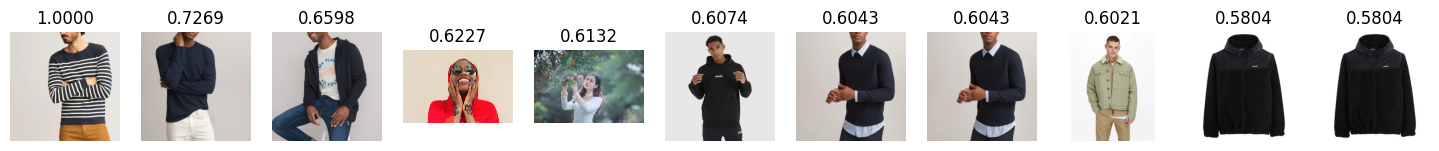

ID: [8, 2, 5, 11, 1, 6, 0, 4, 9, 10, 3]


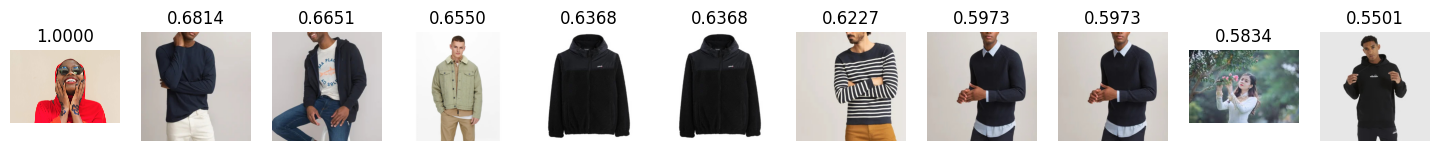

ID: [1, 6, 7, 2, 3, 5, 11, 8, 4, 9, 0]


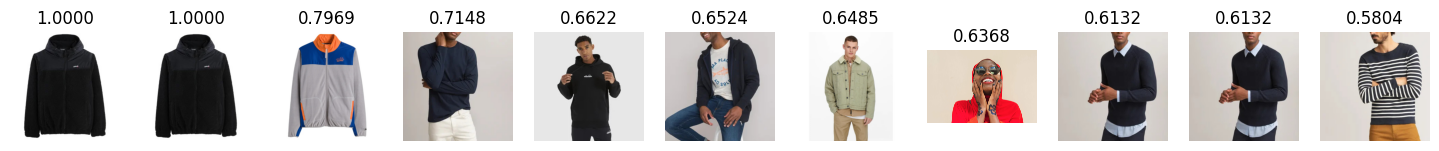

ID: [4, 9, 2, 5, 11, 1, 6, 0, 3, 8, 10]


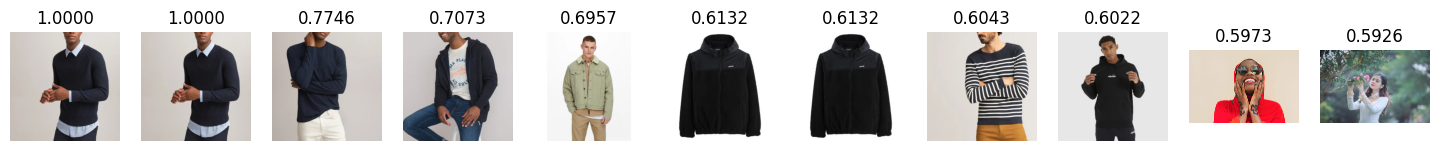

ID: [1, 6, 7, 2, 3, 5, 11, 8, 4, 9, 0]


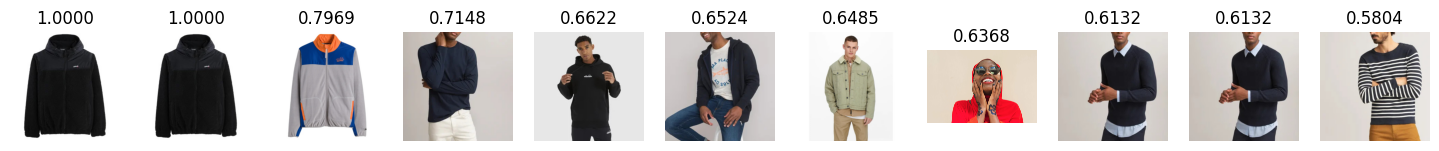

ID: [5, 2, 11, 4, 9, 3, 8, 0, 1, 6, 7]


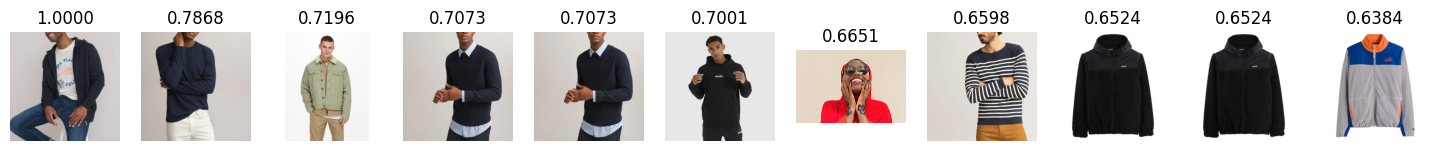

ID: [3, 2, 5, 7, 1, 6, 11, 0, 4, 9, 8]


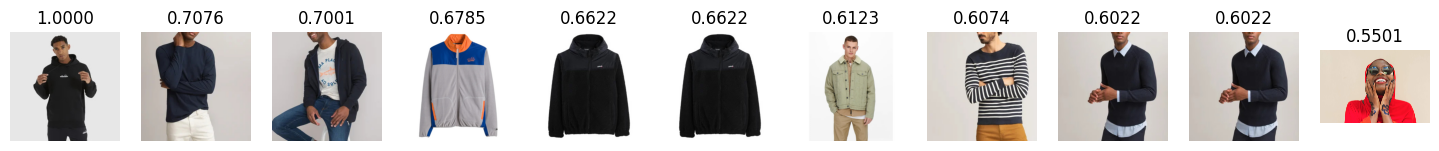

ID: [11, 2, 5, 4, 9, 8, 1, 6, 3, 0, 7]


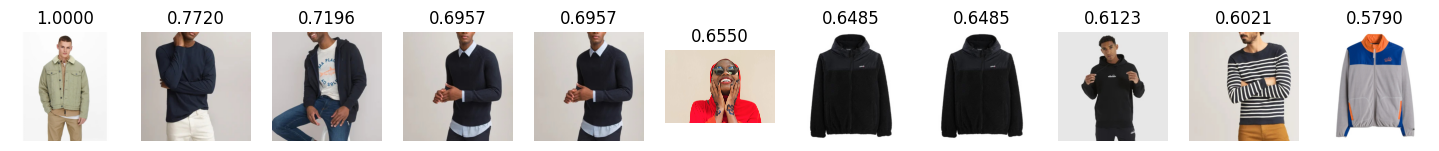

ID: [2, 5, 4, 9, 11, 0, 1, 6, 3, 8, 7]


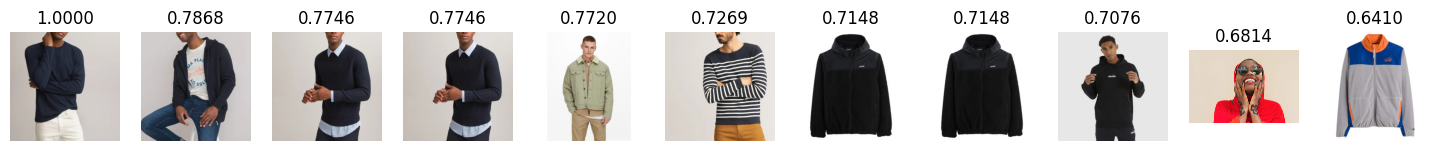

ID: [4, 9, 2, 5, 11, 1, 6, 0, 3, 8, 10]


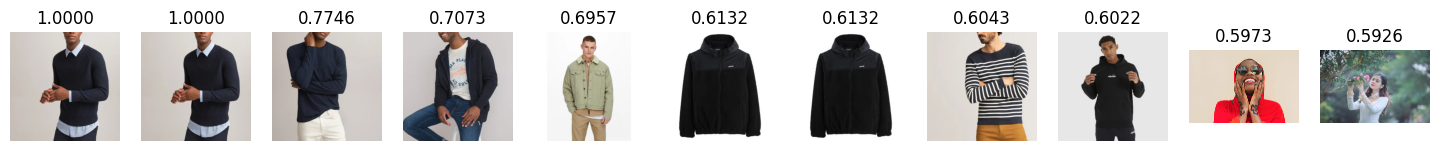

ID: [7, 1, 6, 3, 2, 5, 11, 4, 9, 0, 8]


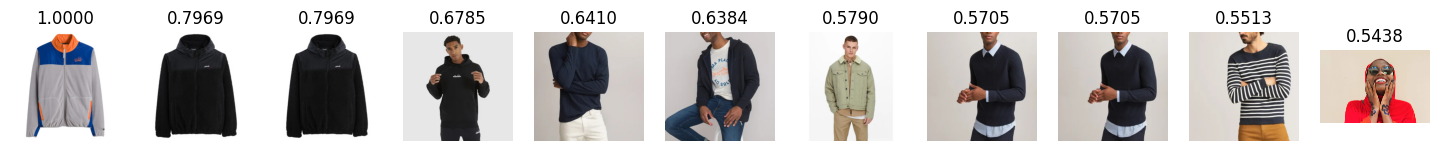

ID: [10, 2, 0, 4, 9, 5, 8, 11, 1, 6, 3]


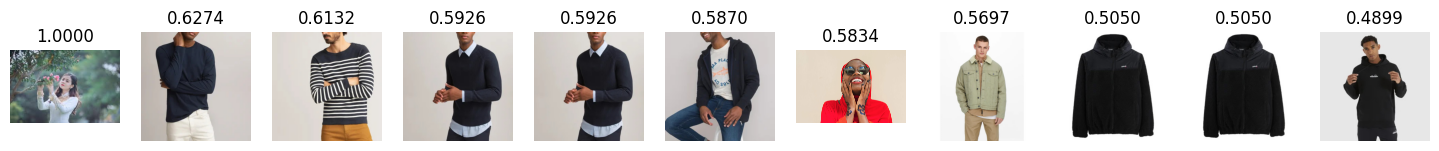

In [40]:
folder = "similitude/"
sims = os.listdir("similitude/")
names =[]
paths_sim = []

datasets = os.listdir("./dataset/")
#print(datasets)
for j, dataset in enumerate(datasets):
        dataset = os.path.join("./dataset/", dataset)
        images = os.listdir(dataset)
        #print(images)
        for image in images:
            for i, sim in enumerate(sims):
                im = '.'.join(image.split('.')[:-1])
                im = int(im)
                s = '.'.join(sim.split('.')[:-1])
                s = int(s)
                if im == s:
                    sim = os.path.join("similitude/", sim)
                    visualisaton(sim)
                    #paths_sim.append(sim)
#print(paths_sim)


        
        
        
#visualisaton(os.path.join(folder, "1.json"))